In [345]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [346]:
PATH = '/Users/dhyungseoklee/Projects/data/'

In [347]:
df = pd.read_csv(PATH + 'air_pollution.csv')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [348]:
# create function to parse date
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

#read csv
df = pd.read_csv(PATH + 'air_pollution.csv', parse_dates = [['year','month','day','hour']],
                 date_parser = parse, index_col = 0)
#drop useless column
df = df.drop(columns = 'No')
# rename index
df.index.name = 'Date'
# rename columns 
df.columns = [['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']]
# drop first 24 hours to drop NaN values
df = df[24:]
# replace rest of NaN with 0
df['pollution'].fillna(0, inplace=True)

df.to_csv(PATH +'airpollution.csv')

In [349]:
df = pd.read_csv(PATH + 'airpollution.csv',header = 0, index_col = 0)
df = df.dropna()
df.index.name = 'Date'
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
Date,,,,,,,,
2010-01-02 00:00:00,129.0,-16.0,-4.0,1020.0,SE,1.79,0.0,0.0
2010-01-02 01:00:00,148.0,-15.0,-4.0,1020.0,SE,2.68,0.0,0.0
2010-01-02 02:00:00,159.0,-11.0,-5.0,1021.0,SE,3.57,0.0,0.0
2010-01-02 03:00:00,181.0,-7.0,-5.0,1022.0,SE,5.36,1.0,0.0
2010-01-02 04:00:00,138.0,-7.0,-5.0,1022.0,SE,6.25,2.0,0.0


In [350]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41757 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
pollution    41757 non-null float64
dew          41757 non-null float64
temp         41757 non-null float64
press        41757 non-null float64
wnd_dir      41757 non-null object
wnd_spd      41757 non-null float64
snow         41757 non-null float64
rain         41757 non-null float64
dtypes: float64(7), object(1)
memory usage: 2.9+ MB


In [351]:
df.columns[0]

'pollution'

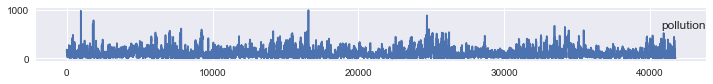

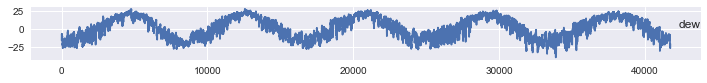

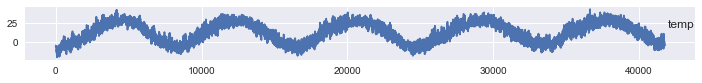

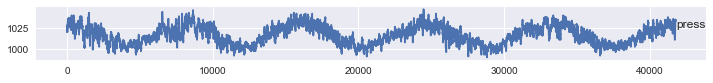

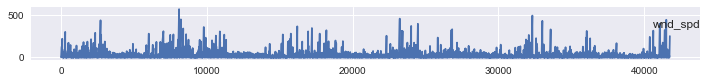

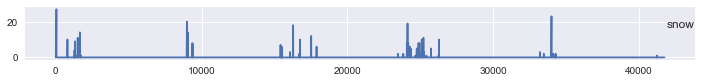

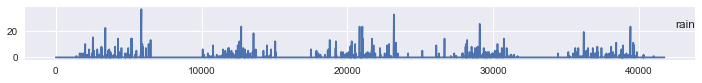

In [352]:
# quick visualization of each column 
values = df.values
columns = [0,1,2,3,5,6,7]
i = 1

for column in columns:
    plt.figure(figsize=(12,8))
    plt.subplot(len(columns),1,i)
    plt.plot(values[: ,column])
    plt.title(df.columns[column], loc = 'right', y = 0.5)
    i+= 1
    plt.show()

## With LSTM Neural Network

Here we are using LSTM from keras to predict pollution based on previous data. Read more about how LSTM model works [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [354]:
# now frame the dataset as a supervised learning problem and normalize

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    #input sequence (t-n ....t-1)
    # shifting +1 so that we can have previous data aligned with target Y
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'''var{j+1}(t-{i})''') for j in range(n_vars)]
        
    #forecasting sequence (t, t+1 .....t+n) 
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'''var{j+1}(t)''') for j in range(n_vars)]
        else:
            names += [(f'''var{j+1}(t+{i})''')  for j in range(n_vars)]
    
    #put it together
    agg = pd.concat(cols,axis = 1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [355]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

le = LabelEncoder()
sc = MinMaxScaler(feature_range = (0,1))

values = df.values
values[:,4] = le.fit_transform(values[:,4]) #Integer Encoding string
values_sc = sc.fit_transform(values)

# transform into supervised learning
reframed = series_to_supervised(values_sc,1,1)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]],axis = 1, inplace = True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002372,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545455,0.666667,0.005522,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563636,0.666667,0.008690,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563636,0.666667,0.010265,0.074074,0.0,0.109658
6,0.109658,0.485294,0.213115,0.563636,0.666667,0.011840,0.111111,0.0,0.105634
7,0.105634,0.485294,0.213115,0.581818,0.666667,0.015008,0.148148,0.0,0.124748
8,0.124748,0.485294,0.229508,0.600000,0.666667,0.018176,0.000000,0.0,0.120724
9,0.120724,0.470588,0.213115,0.600000,0.666667,0.021344,0.000000,0.0,0.132797
10,0.132797,0.485294,0.229508,0.618182,0.666667,0.024512,0.000000,0.0,0.140845


Data Preparation is done. some of our data characteristics:
<br>
- time step of one hour
- integer encoded wind direction

We can perhaps play with these characteristics to build models differently

In [356]:
# we will only use one year worth of data for training in this model to speed up the process
values = reframed.values
n_train_hours = 365*24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :] 

# split into inputs and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

#reshape it to 3D expected by LSTM model [samples, timestep, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8760, 1, 8) (8760,) (32996, 1, 8) (32996,)


In [83]:
# baseline LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

K.clear_session()

model = Sequential()
model.add(LSTM(100,  input_shape = (X_train.shape[1], X_train.shape[2]))) # or input_dim = 8
model.add(Dense(1))
opt = Adam(lr = 0.001)
model.compile(loss = 'mse',optimizer = opt)

Train on 8760 samples, validate on 32996 samples
Epoch 1/25
 - 1s - loss: 0.0050 - val_loss: 0.0020
Epoch 2/25
 - 1s - loss: 0.0010 - val_loss: 7.8870e-04
Epoch 3/25
 - 1s - loss: 7.6351e-04 - val_loss: 6.2373e-04
Epoch 4/25
 - 1s - loss: 7.4084e-04 - val_loss: 5.8669e-04
Epoch 5/25
 - 1s - loss: 7.3586e-04 - val_loss: 6.0464e-04
Epoch 6/25
 - 1s - loss: 7.4484e-04 - val_loss: 5.7408e-04
Epoch 7/25
 - 1s - loss: 7.2975e-04 - val_loss: 5.9140e-04
Epoch 8/25
 - 1s - loss: 7.3200e-04 - val_loss: 5.5765e-04
Epoch 9/25
 - 1s - loss: 7.2568e-04 - val_loss: 5.7205e-04
Epoch 10/25
 - 1s - loss: 7.3220e-04 - val_loss: 5.6323e-04
Epoch 11/25
 - 1s - loss: 7.2283e-04 - val_loss: 6.0433e-04
Epoch 12/25
 - 1s - loss: 7.2101e-04 - val_loss: 5.6060e-04
Epoch 13/25
 - 1s - loss: 7.4501e-04 - val_loss: 5.7112e-04
Epoch 14/25
 - 1s - loss: 7.3541e-04 - val_loss: 5.9060e-04
Epoch 15/25
 - 1s - loss: 7.2742e-04 - val_loss: 5.8465e-04
Epoch 16/25
 - 1s - loss: 7.2602e-04 - val_loss: 5.7654e-04
Epoch 17/25


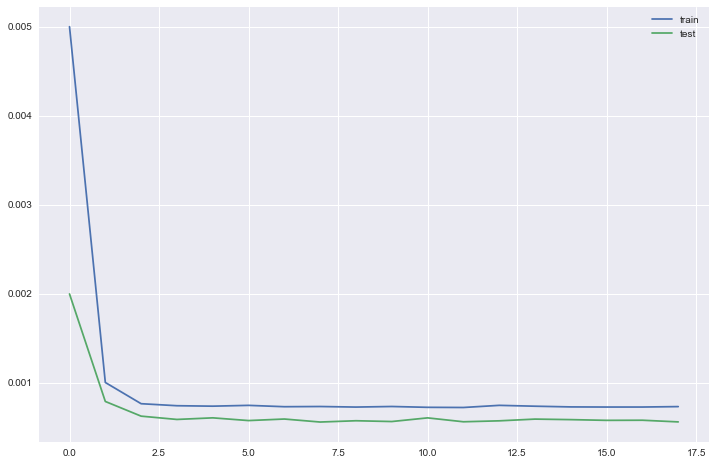

In [84]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

es = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', verbose = 0)

history = model.fit(X_train, y_train, 
                    epochs = 25,
                    batch_size = 64,
                    verbose = 2,
                    callbacks = [es],
                    validation_data = (X_test, y_test))

plt.figure(figsize = (12,8))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

Making prediction using the model and evaluating model

In [85]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
r2_score(y_test,y_pred)

0.9352002494959728

In [379]:
# calculating root mean squared error
from sklearn.metrics import mean_squared_error
import math as m

#invert scaling for forecast
X_test_reshape = X_test.reshape(X_test.shape[0], X_test.shape[2])
y_fc = np.concatenate((y_pred, X_test_reshape[:,1:]),axis=1) # inverse_transform requires all data
inv_y_pred = sc.inverse_transform(y_fc)
inv_y_pred_target = inv_y_pred[:,0] # splitting only target

#invert scaling for actual
y_test= y_test.reshape(len(y_test),1)
y_ac = np.concatenate((y_test,X_test_reshape[:, 1:]),axis = 1)
inv_y_ac = sc.inverse_transform(y_ac)
inv_y_ac_target = inv_y_ac[:,0]

In [87]:
rmse = m.sqrt(mean_squared_error(inv_y_ac_target, inv_y_pred_target))
print(f'''Test rmse: {rmse}''')

Test rmse: 23.50397525291289


we obtain r2 score of 0.92 and rmse of 23.5, which shows that the model makes pretty accurate prediction of pollution number in next hour based on the past data

In [88]:
# prediction on test dataset
f_pred = pd.DataFrame()
f_pred['pollution score prediction'] = inv_y_pred_target
dates = df[n_train_hours+1:].index
f_pred.index = dates
f_pred.head()

,pollution score prediction
Date,
2011-01-31 22:00:00,62.396973
2011-01-31 23:00:00,61.735614
2011-02-01 00:00:00,52.434599
2011-02-01 01:00:00,33.227916
2011-02-01 02:00:00,42.936713


### With FB Prophet

In [450]:
# scaled dataframe
df_sc = pd.DataFrame(values_sc)
df_sc.columns = df.columns
df_sc.index = df.index
# rename as required by prophet
df_p = df_sc.rename(columns = {'pollution' : 'y'}) 
df_p['ds'] = df_sc.index
df_p = df_p[['ds','y','dew','temp','press','wnd_dir','wnd_spd','snow','rain']]
df_p = df_p.reset_index(drop=True)
df_p.head()

,ds,y,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.666667,0.002372,0.000000,0.0
1,2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0
2,2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.666667,0.005522,0.000000,0.0
3,2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.666667,0.008690,0.037037,0.0
4,2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.666667,0.010265,0.074074,0.0


In [451]:
# scale time series data to every 12 hours for faster training
df_phr = df_p[::12]

# train test split
split = round(0.7*len(df_phr))
train_pp = df_phr[:split]
test_pp = df_phr[split:]
print(train.shape, test.shape)

(29230, 8) (12527, 8)


In [452]:
# instantiate prophet mode with parameters 
from fbprophet import Prophet
p = Prophet(mcmc_samples = 300, interval_width = 0.9, seasonality_mode = 'multiplicative')

In [453]:
# adding regressor for multivariate forecasting
p.add_regressor('dew', prior_scale = 0.5, mode = 'multiplicative')
p.add_regressor('temp', prior_scale = 0.5, mode = 'multiplicative')
p.add_regressor('press', prior_scale = 0.5, mode = 'multiplicative')
p.add_regressor('wnd_dir', prior_scale = 0.5, mode = 'multiplicative')
p.add_regressor('wnd_spd', prior_scale = 0.5, mode = 'multiplicative')
p.add_regressor('snow', prior_scale = 0.5, mode = 'multiplicative')
p.add_regressor('rain', prior_scale = 0.5, mode = 'multiplicative')

In [454]:
p.fit(train_pp)

In [455]:
pred = p.predict(test_pp)
pred = pred[['ds','yhat_lower','yhat','yhat_upper','dew','temp','press','wnd_dir','wnd_spd','snow','rain']]
pred.head()

,ds,yhat_lower,yhat,yhat_upper,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2013-07-22 02:00:00,-0.030791,0.083911,0.194277,1.851114,-0.141522,0.271369,0.016122,-0.000968,0.003352,0.013967
1,2013-07-22 20:00:00,-0.039818,0.071151,0.188340,1.750478,-0.178937,0.293360,0.016122,0.000118,0.003352,0.013967
2,2013-07-23 08:00:00,-0.052124,0.060962,0.179109,1.649841,-0.166465,0.315350,0.061314,0.020142,0.003352,0.013967
3,2013-07-23 20:00:00,-0.048366,0.072348,0.180233,1.649841,-0.203881,0.403311,0.016122,-0.003207,0.003352,0.013967
4,2013-07-24 08:00:00,-0.041874,0.071804,0.182377,1.851114,-0.203881,0.337340,-0.029071,0.010515,0.003352,0.013967


In [457]:
# inverse transform to original scale
pred_n = pred.drop(columns = ['ds','snow','rain'])
inv_pred_n = sc.inverse_transform(pred_n)
inv_pred_target = inv_pred_n[:,1]

test_n = test_pp
test_n.index = test_pp['ds']
test_n = test_n.drop(columns = 'ds')
inv_test_n = sc.inverse_transform(test_n)
inv_test_target = inv_test_n[:,0]

In [458]:
from sklearn.metrics import mean_squared_error
rmse = m.sqrt(mean_squared_error(inv_test_target, inv_pred_target))
print(rmse)

157.4933364267674


In [460]:
# prediction on test set
f_pred = pd.DataFrame()
f_pred['prediction'] = abs(inv_pred_target)
f_pred.index = pred['ds']
f_pred.head()

,prediction
ds,
2013-07-22 02:00:00,34.294077
2013-07-22 20:00:00,35.161719
2013-07-23 08:00:00,35.854552
2013-07-23 20:00:00,35.080352
2013-07-24 08:00:00,35.117354


Prediction is significantly worse than LSTM. It is likely due to smaller training set for faster training (1 hour interval vs 12 hours interval)

#### future prediction

In [463]:
future_data =p.make_future_dataframe(periods = len(test_pp))
future_data.tail()

,ds
3475,2016-05-26 14:00:00
3476,2016-05-27 14:00:00
3477,2016-05-28 14:00:00
3478,2016-05-29 14:00:00
3479,2016-05-30 14:00:00


In [467]:
# add regressors to the future data
regressors = df_phr[['dew','temp','press','wnd_dir','wnd_spd','snow','rain']].reset_index()
future_d = pd.concat([future_data,regressors],axis =1)
future_d = future_d.drop(columns = 'index')
future_d.head()

,ds,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,0.352941,0.245902,0.527273,0.666667,0.002372,0.000000,0.0
1,2010-01-02 12:00:00,0.470588,0.229508,0.636364,0.666667,0.041130,0.000000,0.0
2,2010-01-03 00:00:00,0.485294,0.213115,0.654545,0.666667,0.102842,0.148148,0.0
3,2010-01-03 12:00:00,0.426471,0.163934,0.545455,0.666667,0.186677,0.629630,0.0
4,2010-01-04 00:00:00,0.382353,0.114754,0.581818,0.333333,0.027679,0.000000,0.0


In [468]:
# predict on extra regressors
forecast = p.predict(future_d)

In [469]:
 forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3475,2016-05-26 14:00:00,-0.103863,-0.575241,0.425720
3476,2016-05-27 14:00:00,-0.097200,-0.563213,0.384733
3477,2016-05-28 14:00:00,-0.109185,-0.608689,0.430136
3478,2016-05-29 14:00:00,-0.154150,-0.892115,0.597422
3479,2016-05-30 14:00:00,-0.231329,-1.325794,0.905268


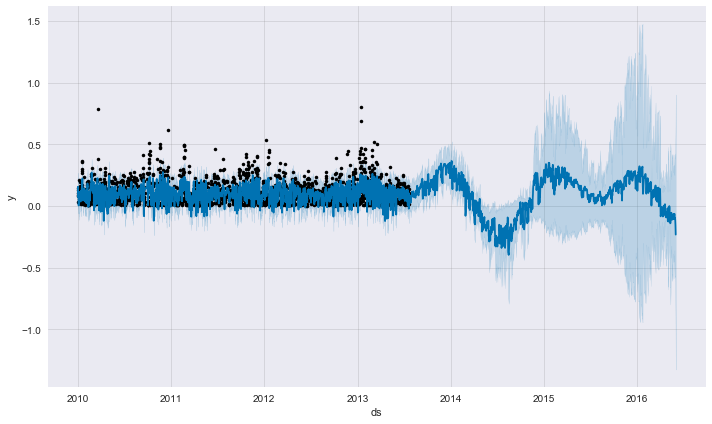

In [472]:
# plotting forecast
fig1 = p.plot(forecast)
fig1;

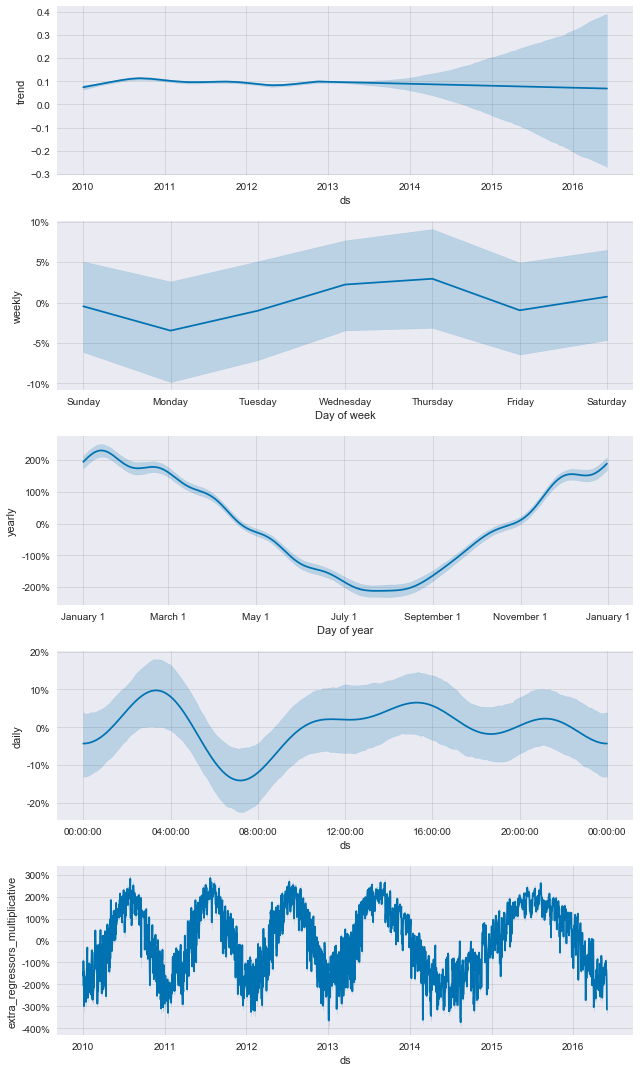

In [473]:
f = p.plot_components(forecast)

## VARMA

Read more about different types of classic time series forecast modeling [here](https://medium.com/greyatom/time-series-b6ef79c27d31)

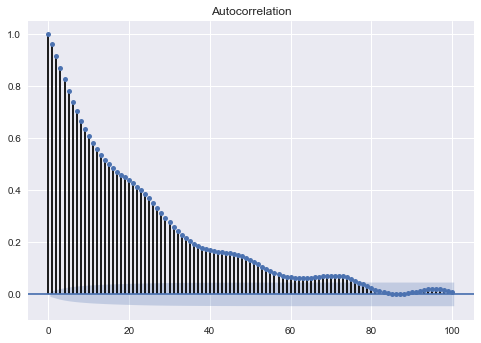

In [357]:
# autocorrelation plot 
plot_acf(df['pollution'], lags = 100);

In [358]:
# checking stationarity (since eigenvalues < 1 --> stationary)
from statsmodels.tsa.vector_ar.vecm import coint_johansen
coint_johansen(df_sc,-1,1).eig

array([2.16527789e-01, 6.45775862e-02, 4.91613739e-02, 4.46838093e-02,
       3.32712510e-02, 2.51000133e-02, 1.25258710e-03, 8.16727480e-05])

In [372]:
# train test split
split = round(0.7*len(df_sc))
train = df_sc[:split].values
test = df_sc[split:].values

In [374]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

model = VAR(endog=train)
model_fit = model.fit()

In [375]:
# prediction 
yhat = model_fit.forecast(model_fit.y, steps = len(test))

In [376]:
yhat.shape

(12527, 8)

In [377]:
test.shape

(12527, 8)

In [380]:
# inverse scaling
inv_yhat = sc.inverse_transform(yhat)[:,0]
inv_y = sc.inverse_transform(test)[:,0]

rmse = m.sqrt(mean_squared_error(inv_y, inv_yhat))
print(rmse)

90.82195712287785


In [381]:
# prediction 
f_pred = pd.DataFrame()
f_pred['pollution prediction'] = inv_yhat
f_pred.index = test.index
f_pred.head()

,pollution prediction
Date,
2013-07-22 00:00:00,58.394708
2013-07-22 01:00:00,62.101983
2013-07-22 02:00:00,65.405820
2013-07-22 03:00:00,68.418034
2013-07-22 04:00:00,71.189215


Not as impressive accuracy as we obtained from LSTM 